## **Detecting Coronavirus Infections through Chest X-Ray Images**








In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
driveProjectDir = '/content/gdrive/My Drive/DeepLearning/Assignment_05/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns


## Loading Data

---



In [7]:

Datatransforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                     ])

data_dir = driveProjectDir+ "/Dataset"

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train'    ,  transform=Datatransforms )
test_data = datasets.ImageFolder(data_dir + '/test'      ,  transform=Datatransforms)
val_data = datasets.ImageFolder(data_dir + '/validation' , transform=Datatransforms)

visualiztion_data_loader = torch.utils.data.DataLoader(train_data, batch_size = 8, shuffle=True ) 
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 50, shuffle=True )
testloader  = torch.utils.data.DataLoader(test_data, batch_size  =50, shuffle=True )
valloader   = torch.utils.data.DataLoader(val_data, batch_size   =50, shuffle=True)

class_names = train_data.classes
print(" Required Classes: ", ', '.join(class_names))

 Required Classes:  infected, normal


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


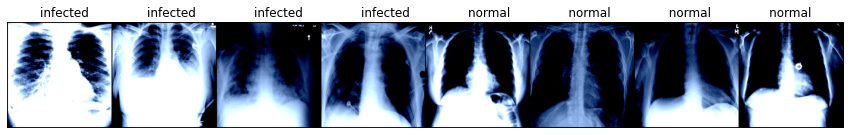

In [0]:
#****************************************************************Visualization of Loaded Data************************************888
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(15,8))
    imshow(out, title='               '.join([class_names[x] for x in classes]))

# Get a batch of training data
inputs, classes = next(iter(visualiztion_data_loader))
show_databatch(inputs, classes)

## Functions

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#***********************************************************************************************************************************
#                                               To Train model
#***********************************************************************************************************************************
def trainModel (model , trainingDataLoader , ValidationDataLoader ,datapath, epochs , lr = 0.001, momentum = 0.9 ):
  """
  Input : model, 
        trainingData,
        ValidationData
        Other parameter 

  return : trained model  

  Description: This function takes model and train it
             then save model to data file and also create log file 
             which saves the training and validation loss and accuracy computed during training


  """
  Epochs = epochs
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  model.to(device)
  model.train()

  LogData = {}
  LogData['Epochs'] = []
  LogData["Loss"] = {'train' : [] , 'val': []}
  LogData["Accuracy"] = {'train' : [] , 'val': []}

  for epoch in range(Epochs):  # loop over the dataset multiple times
      print("*********************** Epoch ",epoch, " ***************************************")
      #********************************* Train Data**********************************************
      running_loss = 0.0
      batches_number = 0
      correct = 0
      total = 0
      pbar = tqdm(enumerate(trainingDataLoader), position=0, leave=True)
      for i, data in pbar:
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)               #----> forward pass
          loss = criterion(outputs, labels)     #----> compute loss
          loss.backward()                       #----> backward pass
          optimizer.step()                      #----> weights update

          # print statistics
          running_loss += loss.item()
          pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainingDataLoader.dataset),
                  100. * i / len(trainingDataLoader),
                  loss.data.item()))
          
          #accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          batches_number = i

      LogData["Loss"]["train"].append(np.round((running_loss/(batches_number+1)),decimals=4))
      LogData["Accuracy"]["train"].append(np.round((100 * correct / total),decimals=4))
      
      #********************************* Validation Data**********************************************
      running_loss = 0.0
      batches_number = 0
      correct = 0
      total = 0

      for i, data in enumerate(ValidationDataLoader):
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)               #----> forward pass
          loss = criterion(outputs, labels)     #----> compute loss
          # print statistics
          running_loss += loss.item()
          batches_number = i

          #accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      LogData["Epochs"].append(epoch)
      LogData["Loss"]["val"].append(np.round((running_loss/(batches_number+1)),decimals=4))
      LogData["Accuracy"]["val"].append(np.round((100 * correct / total),decimals=4))
      
      print("*******************************************************************************")
      print("Loss: \n Train Data:"      ,LogData["Loss"]["train"][epoch], "\t Validation Data:" , LogData["Loss"]["val"][epoch] )
      print("Accuracy: \n Train Data:"      ,LogData["Accuracy"]["train"][epoch], "\t Validation Data:" , LogData["Accuracy"]["val"][epoch] )

      #Saving Model and LogData   
      torch.save(model.state_dict(), driveProjectDir+datapath+'.pth')
      f = open(driveProjectDir+datapath+'_log.txt' ,mode='w')
      f.write(str(LogData))
      f.close()


  plt.figure(figsize=(15,4))
  plt.subplot(1,2,1)
  plt.gca().set(title='Loss Curve over epochs', ylabel='Loss', xlabel='epochs')            
  plt.plot(LogData['Epochs'],LogData["Loss"]["train"] , label="Train")
  plt.plot(LogData['Epochs'],LogData["Loss"]["val"] , label="Validation")
  plt.legend()

  plt.subplot(1,2,2) 
  plt.gca().set(title='Accuracy Curve over epochs', ylabel='Accuracy', xlabel='epochs')            
  plt.plot(LogData['Epochs'],LogData["Accuracy"]['train'] , label="Train")
  plt.plot(LogData['Epochs'],LogData["Accuracy"]['val'] , label="Validation")
  plt.legend()

  plt.savefig(driveProjectDir+datapath+ "_plot.png")
  
  return model



In [0]:
#***********************************************************************************************************************************
#                                               Evalute model
#***********************************************************************************************************************************

def modelAnalysis(model, DataLoader):
  if torch.cuda.is_available():
      model.cuda()

  BestClassifyImg  = {'class0': {'prob' : [] , 'Images' : []  },
                      'class1': {'prob' : [] , 'Images' : [] }}

  WorstClassifyImg =  {'class0': {'prob' : [] , 'Images' : [] },
                      'class1': {'prob' : [] , 'Images' : [] }}

  correct = 0
  total = 0
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

  with torch.no_grad():
      for i , data in enumerate(DataLoader):

        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        output = outputs.cpu().data.numpy()
        pred =   predicted.cpu().numpy()
        label =  labels.cpu().numpy()

        #To Get best and worst classify images
        for j in range(len(labels)):
          c = str(pred[j])
          l = str(label[j])
          o = output[j][int(c)]

          #Best classified Images
          if( len(BestClassifyImg['class'+c]['prob']) == 2):   
            maxprob = BestClassifyImg['class'+c]['prob'][0]
            maxprob2 =  BestClassifyImg['class'+c]['prob'][1]

            if(o > maxprob2):
              if(o>maxprob):
                BestClassifyImg['class'+c]['prob'][0] = o
                BestClassifyImg['class'+c]['Images'][0] = images[j]

              else:
                BestClassifyImg['class'+c]['prob'][1] = o
                BestClassifyImg['class'+c]['Images'][1] = images[j]
            
          else:
              BestClassifyImg['class'+c]['prob'].append(o)
              BestClassifyImg['class'+c]['Images'].append(images[j])

          #Images which are labeled in wrong class 
          if ( c != l ): 
            if( len(WorstClassifyImg['class'+c]['prob']) == 2):   
              maxprob = WorstClassifyImg['class'+c]['prob'][0]
              minprob2 =  WorstClassifyImg['class'+c]['prob'][1]

              if(o > maxprob2):
                if(o > maxprob):
                  WorstClassifyImg['class'+c]['prob'][0] = o
                  WorstClassifyImg['class'+c]['Images'][0] = images[j]
                else:
                  WorstClassifyImg['class'+c]['prob'][1] = o
                  WorstClassifyImg['class'+c]['Images'][1] = images[j]
            else:
              WorstClassifyImg['class'+c]['prob'].append(o)
              WorstClassifyImg['class'+c]['Images'].append(images[j])

  ShowImages(BestClassifyImg ,   'Top 2 Best Classified Images')
  ShowImages(WorstClassifyImg , 'Top 2 Worst Classified Images')

  conf_mat = confusion_matrix(labelslist.numpy(), predlist.numpy())  

  tn, fp, fn, tp = conf_mat.ravel()
  precision = tp / (tp + fp )
  recall = tp / (tp + fn )

  accuracy = (tp + tn)/ (tp + tn  + fp + fn)
  f1 = 2* (precision*recall) / (precision + recall )
  printConfusion_Matrix(conf_mat)
  print("Accuracy:", np.round(accuracy,decimals=4) *100 , "\t F1 Score:" , np.round(f1,decimals=4))


def ShowImages(imageObj , title):
  fig= plt.figure(figsize=(10,4))

  plt.subplot(1,4,1)
  plt.imshow(imageObj['class0']['Images'][0].cpu().numpy().transpose((1, 2, 0)))
  plt.title("Infected")
  plt.axis('off')

  plt.subplot(1,4,2)
  plt.imshow(imageObj['class0']['Images'][1].cpu().numpy().transpose((1, 2, 0))) 
  plt.title("Infected")
  plt.axis('off')

  plt.subplot(1,4,3)
  plt.imshow(imageObj['class1']['Images'][0].cpu().numpy().transpose((1, 2, 0)))
  plt.title("Normal")
  plt.axis('off')

  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(imageObj['class1']['Images'][1].cpu().numpy().transpose((1, 2, 0))) 
  plt.title("Normal")
  plt.axis('off')
  fig.suptitle(title)
#fig.suptitle('Top 2 Best Classified Images ')


def printConfusion_Matrix(c):
  plt.pause(0.01)
  plt.figure()
  ax= plt.subplot()
  sns.heatmap(c, annot=True, ax = ax  ,cmap='Greens' ,fmt='g'); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);



## **TASK NO 1**

>## VGG16

In [56]:
vgg16 = models.vgg16(pretrained=True)
# Freeze training for all layers of Model
for param in vgg16.features.parameters():
    param.require_grad = False

rollnumber_neurons = (16 * 10 )  + 100
num_features = vgg16.classifier[0].in_features

newClassifierLayers = [nn.Linear(num_features, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers.extend([nn.Linear(rollnumber_neurons, len(class_names))])
vgg16.classifier = nn.Sequential(*newClassifierLayers)
vgg16.load_state_dict(torch.load(driveProjectDir+'vgg16_FC_Only_01.pth'))
#print(vgg16)

<All keys matched successfully>

In [0]:
 trainedmodel = trainModel(vgg16 , trainloader , valloader ,'vgg16_FC_Only', 10 , lr = 0.001, momentum = 0.9 )
 vgg16 = trainedmodel 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


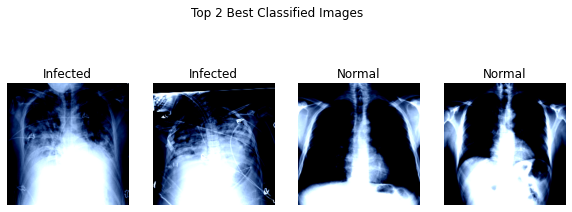

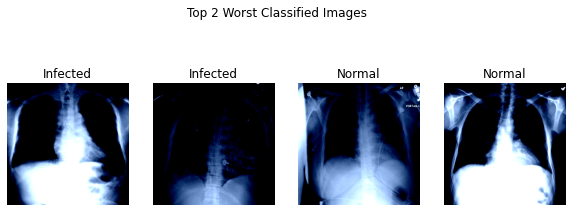

Accuracy: 97.2 	 F1 Score: 0.9764


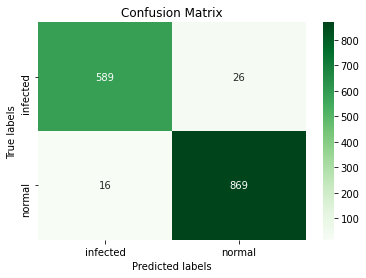

In [59]:
modelAnalysis(vgg16 , testloader)

> ## Resnet-18

In [0]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.require_grad = False


rollnumber_neurons = (16 * 10 )  + 100
num_features_resnet = resnet18.fc.in_features

newClassifierLayers_resnet = [nn.Linear(num_features_resnet, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers_resnet.extend([nn.Linear(rollnumber_neurons, len(class_names))])
resnet18.fc = nn.Sequential(*newClassifierLayers_resnet)
#print(resnet18)


0it [00:00, ?it/s]

*********************** Epoch  0  ***************************************


Train Epoch: 0 [11950/12000 (100%)]	Loss: 0.263758: : 240it [04:41,  1.17s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.3154 	 Validation Data: 0.2911
Accuracy: 
 Train Data: 86.1917 	 Validation Data: 89.1333
*********************** Epoch  1  ***************************************


Train Epoch: 1 [11950/12000 (100%)]	Loss: 0.145767: : 240it [04:39,  1.17s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1875 	 Validation Data: 0.264
Accuracy: 
 Train Data: 92.8083 	 Validation Data: 89.7333
*********************** Epoch  2  ***************************************


Train Epoch: 2 [11950/12000 (100%)]	Loss: 0.085519: : 240it [04:40,  1.17s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1498 	 Validation Data: 0.2584
Accuracy: 
 Train Data: 94.525 	 Validation Data: 90.3333
*********************** Epoch  3  ***************************************


Train Epoch: 3 [11950/12000 (100%)]	Loss: 0.127047: : 240it [04:39,  1.16s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1135 	 Validation Data: 0.2785
Accuracy: 
 Train Data: 95.7917 	 Validation Data: 90.4
*********************** Epoch  4  ***************************************


Train Epoch: 4 [11950/12000 (100%)]	Loss: 0.100163: : 240it [04:38,  1.16s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0819 	 Validation Data: 0.326
Accuracy: 
 Train Data: 96.875 	 Validation Data: 89.6667
*********************** Epoch  5  ***************************************


Train Epoch: 5 [11950/12000 (100%)]	Loss: 0.012976: : 240it [04:38,  1.16s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0593 	 Validation Data: 0.3357
Accuracy: 
 Train Data: 98.0167 	 Validation Data: 90.2
*********************** Epoch  6  ***************************************


Train Epoch: 6 [11950/12000 (100%)]	Loss: 0.031566: : 240it [04:39,  1.17s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.036 	 Validation Data: 0.3636
Accuracy: 
 Train Data: 98.9167 	 Validation Data: 90.0667
*********************** Epoch  7  ***************************************


Train Epoch: 7 [11950/12000 (100%)]	Loss: 0.017984: : 240it [04:39,  1.16s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0173 	 Validation Data: 0.3787
Accuracy: 
 Train Data: 99.5833 	 Validation Data: 90.9333
*********************** Epoch  8  ***************************************


Train Epoch: 8 [11950/12000 (100%)]	Loss: 0.002675: : 240it [04:36,  1.15s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0134 	 Validation Data: 0.4112
Accuracy: 
 Train Data: 99.525 	 Validation Data: 90.7333
*********************** Epoch  9  ***************************************


Train Epoch: 9 [11950/12000 (100%)]	Loss: 0.023817: : 240it [04:36,  1.15s/it]


*******************************************************************************
Loss: 
 Train Data: 0.0101 	 Validation Data: 0.4697
Accuracy: 
 Train Data: 99.7167 	 Validation Data: 90.2667


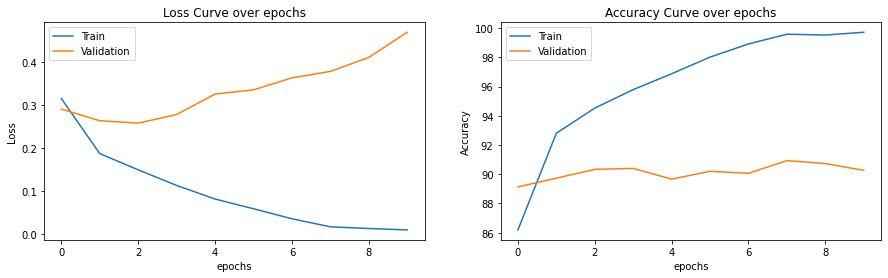

In [66]:
trainedmodel = trainModel(resnet18 , trainloader , valloader ,'‘res18_FC_Only', 10 , lr = 0.001, momentum = 0.9 )

In [0]:
#vgg16.load_state_dict(torch.load(driveProjectDir+'vgg16_FC_Only.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


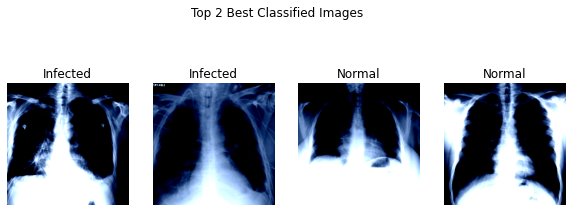

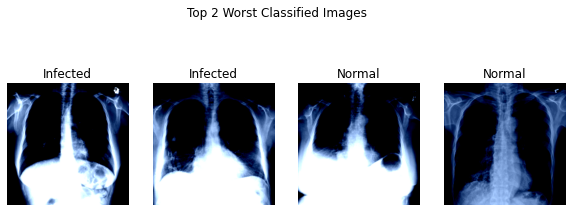

Accuracy: 96.2 	 F1 Score: 0.968


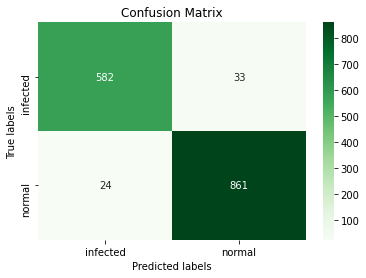

In [68]:
modelAnalysis(trainedmodel , testloader)

## **TASK NO 2**

>## VGG16

In [0]:
 #Training Whole Network
 vgg16 = models.vgg16(pretrained=True)

rollnumber_neurons = (16 * 10 )  + 100
num_features = vgg16.classifier[0].in_features

newClassifierLayers = [nn.Linear(num_features, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers.extend([nn.Linear(rollnumber_neurons, len(class_names))])
vgg16.classifier = nn.Sequential(*newClassifierLayers)
#vgg16.load_state_dict(torch.load(driveProjectDir+'vgg16_FC_Only.pth'))
#print(vgg16)

0it [00:00, ?it/s]

*********************** Epoch  0  ***************************************


Train Epoch: 0 [11950/12000 (100%)]	Loss: 0.193521: : 240it [1:01:40, 15.42s/it]


*******************************************************************************
Loss: 
 Train Data: 0.2624 	 Validation Data: 0.235
Accuracy: 
 Train Data: 89.3333 	 Validation Data: 91.0


0it [00:00, ?it/s]

*********************** Epoch  1  ***************************************


Train Epoch: 1 [11950/12000 (100%)]	Loss: 0.179014: : 240it [05:55,  1.48s/it]


*******************************************************************************
Loss: 
 Train Data: 0.1728 	 Validation Data: 0.2356
Accuracy: 
 Train Data: 93.7167 	 Validation Data: 91.0


0it [00:00, ?it/s]

*********************** Epoch  2  ***************************************


Train Epoch: 2 [11950/12000 (100%)]	Loss: 0.130020: : 240it [05:55,  1.48s/it]


*******************************************************************************
Loss: 
 Train Data: 0.1409 	 Validation Data: 0.2202
Accuracy: 
 Train Data: 94.825 	 Validation Data: 91.5333


0it [00:00, ?it/s]

*********************** Epoch  3  ***************************************


Train Epoch: 3 [11950/12000 (100%)]	Loss: 0.066642: : 240it [05:53,  1.47s/it]


*******************************************************************************
Loss: 
 Train Data: 0.1137 	 Validation Data: 0.265
Accuracy: 
 Train Data: 95.8 	 Validation Data: 90.0


0it [00:00, ?it/s]

*********************** Epoch  4  ***************************************


Train Epoch: 4 [11950/12000 (100%)]	Loss: 0.076870: : 240it [05:54,  1.48s/it]


*******************************************************************************
Loss: 
 Train Data: 0.0986 	 Validation Data: 0.2743
Accuracy: 
 Train Data: 96.4083 	 Validation Data: 91.3333


0it [00:00, ?it/s]

*********************** Epoch  5  ***************************************


Train Epoch: 5 [11950/12000 (100%)]	Loss: 0.031403: : 240it [05:54,  1.48s/it]


*******************************************************************************
Loss: 
 Train Data: 0.0697 	 Validation Data: 0.2935
Accuracy: 
 Train Data: 97.65 	 Validation Data: 89.9333


0it [00:00, ?it/s]

*********************** Epoch  6  ***************************************


Train Epoch: 6 [11950/12000 (100%)]	Loss: 0.058546: : 240it [05:55,  1.48s/it]


*******************************************************************************
Loss: 
 Train Data: 0.048 	 Validation Data: 0.3708
Accuracy: 
 Train Data: 98.3583 	 Validation Data: 89.0


0it [00:00, ?it/s]

*********************** Epoch  7  ***************************************


Train Epoch: 7 [11950/12000 (100%)]	Loss: 0.033085: : 240it [05:55,  1.48s/it]


*******************************************************************************
Loss: 
 Train Data: 0.0364 	 Validation Data: 0.3852
Accuracy: 
 Train Data: 98.725 	 Validation Data: 91.4


0it [00:00, ?it/s]

*********************** Epoch  8  ***************************************


Train Epoch: 8 [11950/12000 (100%)]	Loss: 0.015657: : 240it [05:55,  1.48s/it]


*******************************************************************************
Loss: 
 Train Data: 0.0208 	 Validation Data: 0.3983
Accuracy: 
 Train Data: 99.2583 	 Validation Data: 91.2


0it [00:00, ?it/s]

*********************** Epoch  9  ***************************************


Train Epoch: 9 [11950/12000 (100%)]	Loss: 0.001002: : 240it [05:54,  1.48s/it]


*******************************************************************************
Loss: 
 Train Data: 0.0201 	 Validation Data: 0.436
Accuracy: 
 Train Data: 99.325 	 Validation Data: 91.4667


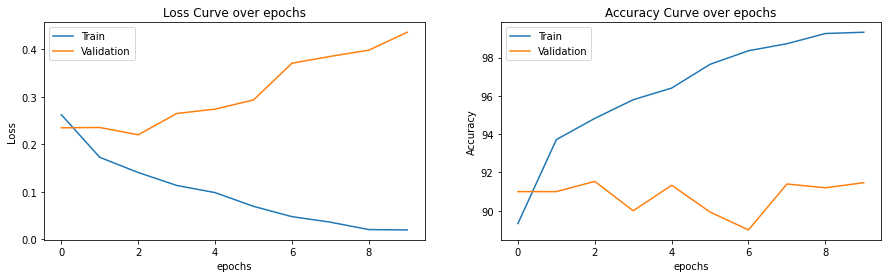

In [61]:
 trainedmodel_VF = trainModel(vgg16 , trainloader , valloader ,'vgg16_entire', 10 , lr = 0.001, momentum = 0.9 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


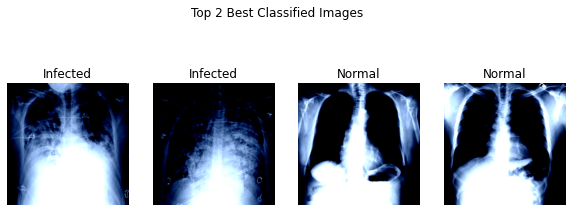

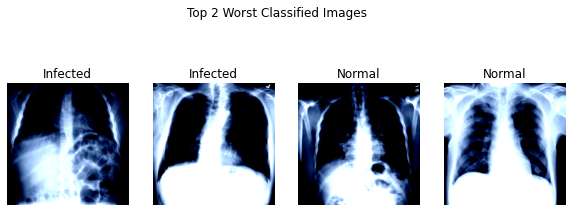

Accuracy: 97.13000000000001 	 F1 Score: 0.976


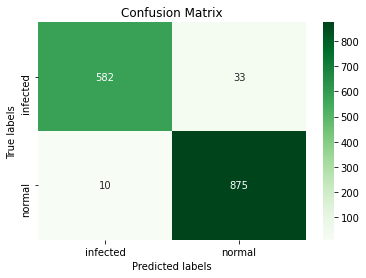

In [67]:
modelAnalysis(vgg16 , testloader)

>## Resnet 

In [0]:
resnet18_F = models.resnet18(pretrained=True)

rollnumber_neurons = (16 * 10 )  + 100
num_features_resnet = resnet18_F.fc.in_features

newClassifierLayers_resnet = [nn.Linear(num_features_resnet, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers_resnet.extend([nn.Linear(rollnumber_neurons, len(class_names))])
resnet18_F.fc = nn.Sequential(*newClassifierLayers_resnet)
#print(resnet18)


0it [00:00, ?it/s]

*********************** Epoch  0  ***************************************


Train Epoch: 0 [11950/12000 (100%)]	Loss: 0.251717: : 240it [04:38,  1.16s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.3267 	 Validation Data: 0.283
Accuracy: 
 Train Data: 85.5083 	 Validation Data: 88.0
*********************** Epoch  1  ***************************************


Train Epoch: 1 [11950/12000 (100%)]	Loss: 0.178716: : 240it [04:37,  1.16s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1902 	 Validation Data: 0.2698
Accuracy: 
 Train Data: 92.7417 	 Validation Data: 89.0
*********************** Epoch  2  ***************************************


Train Epoch: 2 [11950/12000 (100%)]	Loss: 0.093256: : 240it [04:36,  1.15s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1475 	 Validation Data: 0.2651
Accuracy: 
 Train Data: 94.4333 	 Validation Data: 90.2667
*********************** Epoch  3  ***************************************


Train Epoch: 3 [11950/12000 (100%)]	Loss: 0.126161: : 240it [04:35,  1.15s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1188 	 Validation Data: 0.2702
Accuracy: 
 Train Data: 95.6167 	 Validation Data: 90.4
*********************** Epoch  4  ***************************************


Train Epoch: 4 [11950/12000 (100%)]	Loss: 0.057073: : 240it [04:36,  1.15s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0906 	 Validation Data: 0.3082
Accuracy: 
 Train Data: 96.9167 	 Validation Data: 89.0667
*********************** Epoch  5  ***************************************


Train Epoch: 5 [11950/12000 (100%)]	Loss: 0.005708: : 240it [04:36,  1.15s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0591 	 Validation Data: 0.3325
Accuracy: 
 Train Data: 97.8917 	 Validation Data: 89.7333
*********************** Epoch  6  ***************************************


Train Epoch: 6 [11950/12000 (100%)]	Loss: 0.020991: : 240it [04:36,  1.15s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0387 	 Validation Data: 0.3527
Accuracy: 
 Train Data: 98.6333 	 Validation Data: 89.8667
*********************** Epoch  7  ***************************************


Train Epoch: 7 [11950/12000 (100%)]	Loss: 0.030573: : 240it [04:36,  1.15s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0219 	 Validation Data: 0.4215
Accuracy: 
 Train Data: 99.3083 	 Validation Data: 89.7333
*********************** Epoch  8  ***************************************


Train Epoch: 8 [11950/12000 (100%)]	Loss: 0.005759: : 240it [04:36,  1.15s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0139 	 Validation Data: 0.4273
Accuracy: 
 Train Data: 99.6167 	 Validation Data: 90.6
*********************** Epoch  9  ***************************************


Train Epoch: 9 [11950/12000 (100%)]	Loss: 0.006338: : 240it [04:36,  1.15s/it]


*******************************************************************************
Loss: 
 Train Data: 0.0149 	 Validation Data: 0.4751
Accuracy: 
 Train Data: 99.525 	 Validation Data: 89.7333


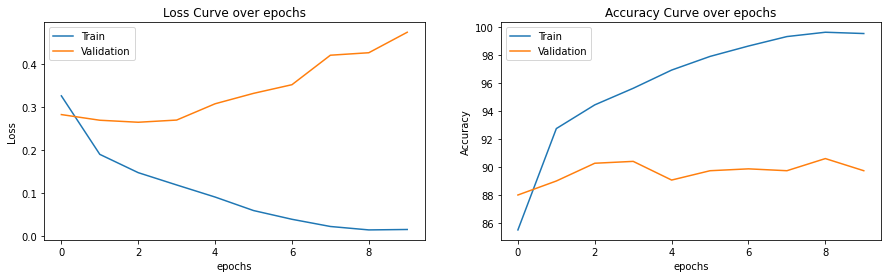

In [70]:
trainedmode_RF = trainModel(resnet18_F , trainloader , valloader ,'res18_entire', 10 , lr = 0.001, momentum = 0.9 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


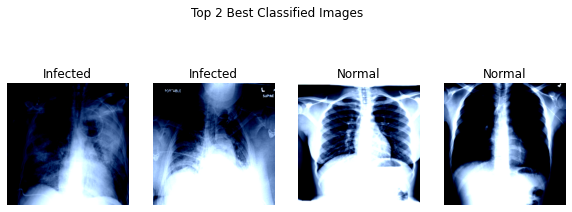

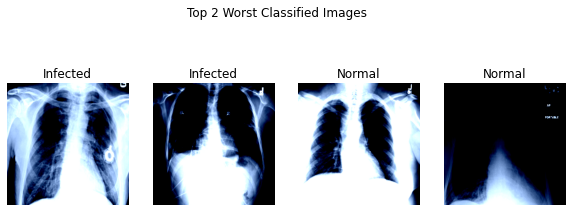

Accuracy: 95.8 	 F1 Score: 0.9646


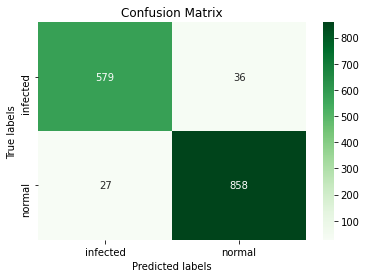

In [72]:
modelAnalysis(trainedmode_RF , testloader)